常用方法
- Face recognition with LBPH and OpenCV
- Face recognition with Dlib,CNN and distance Single layer perceptron calculation
- Face recognition using the webcam

## LBPH (LOCAL BINARY PATTERNS HISTOGRAMS) 演算法原理

![upgit_20240513_1715598788.png](https://raw.githubusercontent.com/kcwc1029/obsidian-upgit-image/main/2024/05/upgit_20240513_1715598788.png)

In [2]:
from PIL import Image
import cv2
import numpy as np
# from google.colab.patches import cv2_imshow
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
import zipfile
path = './Datasets/yalefaces.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

## 預處理圖片

In [6]:
import os

# 分裝資料跟標籤
def get_image_data():
    paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
    faces = []
    ids = []
    for path in paths:
        image = Image.open(path).convert('L')
        image_np = np.array(image, 'uint8')
        id = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))
        ids.append(id)
        faces.append(image_np)
    return np.array(ids), faces

ids, faces = get_image_data()
print(len(ids), len(faces))
faces[0].shape

135 135


(243, 320)

## 訓練LBPH classifier


lbph_classifier = cv2.face.LBPHFaceRecognizer_create()，其中參數：
- radius: 局部二值模式的半径，默认值为 1。
- neighbors: 每个像素点的邻域像素数，默认值为 8。
- grid_x: 网格在 x 方向上的分割数，默认值为 8。
- grid_y: 网格在 y 方向上的分割数，默认值为 8。
- threshold: 阈值，用于识别阈值，默认值为 0。较小的值可能导致更高的误差率，较大的值可能导致更高的错误拒绝率。

In [7]:
lbph_classifier = cv2.face.LBPHFaceRecognizer_create(radius = 4, neighbors=14, grid_x = 9, grid_y = 9)
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

## 開始辨識人臉（單張）

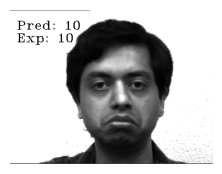

In [9]:
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('./lbph_classifier.yml')


test_image = './yalefaces/test/subject10.sad.gif'
image = Image.open(test_image).convert('L') # 轉灰階
image_np = np.array(image, 'uint8') # 轉np

# 進行預測
prediction = lbph_face_classifier.predict(image_np)

# 拿出預期答案進行比對
import matplotlib.pyplot as plt

expected_output = int(os.path.split(test_image)[1].split('.')[0].replace('subject', ''))
cv2.putText(image_np, 'Pred: ' + str(prediction[0]), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))
cv2.putText(image_np, 'Exp: ' + str(expected_output), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,255,0))

# 顯示圖片
image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(4, 2))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image_rgb)

## 評估 face classifier

<class 'list'> <class 'list'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>

比較答案
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
精確率 0.7


<Axes: >

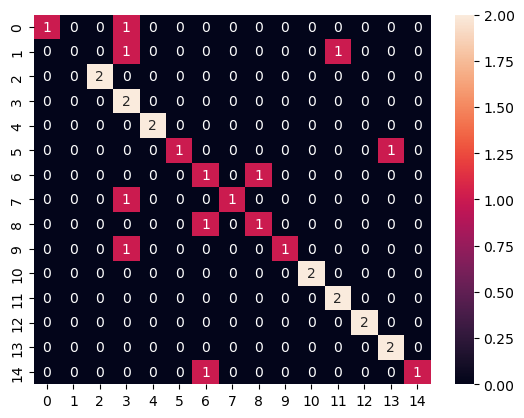

In [11]:
paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
predictions = []
expected_outputs = []
for path in paths:
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')

  prediction, _ = lbph_face_classifier.predict(image_np)
  expected_output = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

  predictions.append(prediction)
  expected_outputs.append(expected_output)

print(type(predictions), type(expected_outputs))
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)
print(type(predictions), type(expected_outputs))
print()
print("比較答案")
print(expected_outputs)
print(expected_outputs)


# 使用混淆矩陣查看狀況
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn
print("精確率", accuracy_score(expected_outputs, predictions))
cm = confusion_matrix(expected_outputs, predictions)
seaborn.heatmap(cm, annot=True)

## 使用Dlib進行人臉辨識

處理dlib無法安裝問題 -> 要先安裝cMake
https://andy6804tw.github.io/2019/10/09/mac-fix-dlib-install/

In [12]:
# !pip install dlib

In [13]:
import dlib
import cv2
# from google.colab.patches import cv2_imshow

## 偵測臉部點

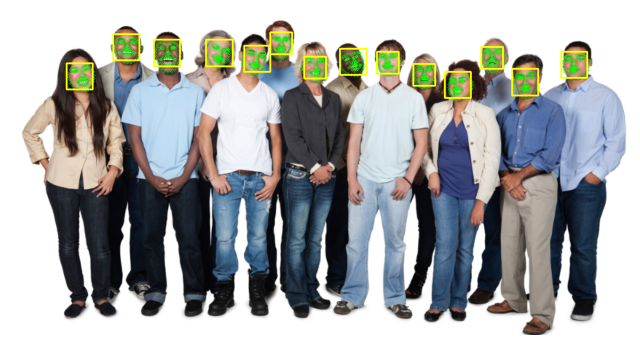

In [16]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./Weights/shape_predictor_68_face_landmarks.dat')
image = cv2.imread('./Images/people2.jpg')
face_detection = face_detector(image, 1)

for face in face_detection:
    points = points_detector(image, face)
    for point in points.parts():
        cv2.circle(image, (point.x, point.y), 2, (0,255,0), 1)

    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image, (l, t), (r, b), (0,255,255), 2)

# 顯示圖片
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
plt.figure(figsize=(8, 6))
plt.axis('off')  # 隱藏坐標軸
plt.imshow(image)

## 檢測臉部描述

相關文獻：https://arxiv.org/abs/1512.03385

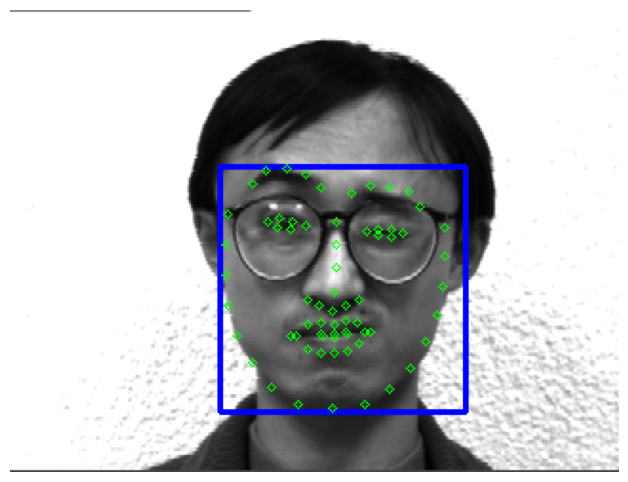

In [22]:
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./Weights/shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('./Weights/dlib_face_recognition_resnet_model_v1.dat')



index = {}
idx = 0
face_descriptors = None

paths = [os.path.join('./yalefaces/train', f) for f in os.listdir('./yalefaces/train')]
for i, path in enumerate(paths):
  #print(path)
  image = Image.open(path).convert('RGB')
  image_np = np.array(image, 'uint8')
  face_detection = face_detector(image_np, 1)
  for face in face_detection:
    l, t, r, b = face.left(), face.top(), face.right(), face.bottom()
    cv2.rectangle(image_np, (l, t), (r, b), (0, 0, 255), 2)

    points = points_detector(image_np, face)
    for point in points.parts():
      cv2.circle(image_np, (point.x, point.y), 2, (0, 255, 0), 1)

    face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
    #print(type(face_descriptor))
    #print(len(face_descriptor))
    #print(face_descriptor)
    face_descriptor = [f for f in face_descriptor]
    #print(face_descriptor)
    face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
    #print(face_descriptor)
    #print(face_descriptor.shape)
    face_descriptor = face_descriptor[np.newaxis, :]
    #print(face_descriptor.shape)
    #print(face_descriptor)

    if face_descriptors is None:
      face_descriptors = face_descriptor
    else:
      face_descriptors = np.concatenate((face_descriptors, face_descriptor), axis = 0)

    index[idx] = path
    idx += 1

    
  # 顯示圖片（顯示一張就好）
  if i == 0:
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(8, 6))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)

## 計算臉與臉間的距離

計算了兩個向量之間的歐式距離

參考網址：https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html#numpy.linalg.norm

In [27]:
print(len(face_descriptors))
print(np.linalg.norm(face_descriptors[131] - face_descriptors[131]))
print(np.linalg.norm(face_descriptors[131] - face_descriptors[130]))
print(np.linalg.norm(face_descriptors[131] - face_descriptors[129]))

# 拿一張圖片與所有圖片進行比較
np.linalg.norm(face_descriptors[0] - face_descriptors, axis = 1)

# 取最小值索引
np.argmin(np.linalg.norm(face_descriptors[0] - face_descriptors[1:], axis = 1))

132
0.0
0.695125969920898
0.683128302332133


19

## 使用 Dlib 進行臉部偵測

預測值
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]
解答
[13  1  3  7  9  8 10 14 15  8  7  1  5 12  4  9 13 10 11  6  5  2  4 14
 11 15  3 12  6  2]


'使用混淆矩陣進行查看'

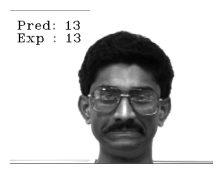

In [35]:
threshold = 0.5  # 設定閾值，用於判斷是否為同一人臉的閾值
predictions = []  # 存儲預測結果的列表
expected_outputs = []  # 存儲預期輸出的列表

# 構建測試圖片路徑列表
paths = [os.path.join('./yalefaces/test', f) for f in os.listdir('./yalefaces/test')]
for i, path in enumerate(paths):
    # 打開並轉換圖片為 RGB 格式
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    # 找出圖片中的人臉位置
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        # 找出人臉的面部特徵點
        points = points_detector(image_np, face)
        # 計算人臉描述符
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]

        # 計算當前人臉描述符與已知人臉描述符之間的歐式距離
        distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
        # 找到與當前人臉描述符距離最小的索引
        min_index = np.argmin(distances)
        # 找到距離最小的距離值
        min_distance = distances[min_index]
        # 如果最小距離小於等於閾值，則認為是同一人臉，否則視為未識別到的人臉
        if min_distance <= threshold:
            name_pred = int(os.path.split(index[min_index])[1].split('.')[0].replace('subject', ''))
        else:
            name_pred = 'Not identified'

        # 獲取真實的人臉標籤
        name_real = int(os.path.split(path)[1].split('.')[0].replace('subject', ''))

        # 將預測結果和真實標籤添加到對應的列表中
        predictions.append(name_pred)
        expected_outputs.append(name_real)

        # 在圖片上標註預測結果和真實標籤
        cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))
        cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))

    # 顯示標註了預測結果和真實標籤的圖片(顯示一張就好)
    if i == 0:
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
        plt.figure(figsize=(4, 2))
        plt.axis('off')  # 隱藏坐標軸
        plt.imshow(image_np)

# 將預測結果和真實標籤轉換為 NumPy 陣列
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

print("預測值")
print(predictions)
print("解答")
print(expected_outputs)

準確率 1.0


<Axes: >

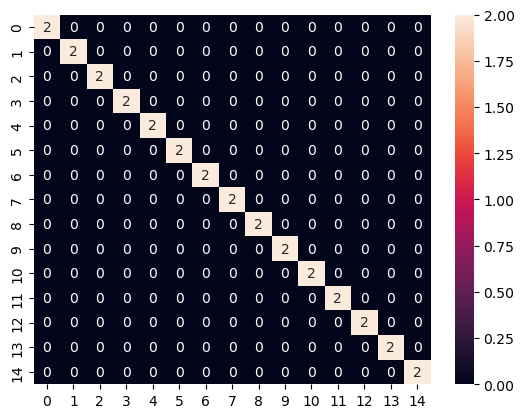

In [36]:
"""使用混淆矩陣進行查看"""
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn
print("準確率", accuracy_score(expected_outputs, predictions))
cm = confusion_matrix(expected_outputs, predictions)
seaborn.heatmap(cm, annot=True)

## Homework

In [38]:
import zipfile
path = './Datasets/jones_gabriel.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [39]:
def get_image_data():
    paths = [os.path.join('./jones_gabriel', f) for f in os.listdir('./jones_gabriel')]
    faces = []
    ids = []
    print(paths)
    for path in paths:
        image = Image.open(path).convert('L')
        image_np = np.array(image, 'uint8')
        id = int(path.split('.')[3])
        ids.append(id)
        faces.append(image_np)
    return np.array(ids), faces


ids, faces = get_image_data()

['./jones_gabriel/person.2.5.jpg', './jones_gabriel/person.2.14.jpg', './jones_gabriel/person.2.15.jpg', './jones_gabriel/person.2.4.jpg', './jones_gabriel/person.2.6.jpg', './jones_gabriel/person.2.17.jpg', './jones_gabriel/person.2.16.jpg', './jones_gabriel/person.2.7.jpg', './jones_gabriel/person.2.3.jpg', './jones_gabriel/person.2.12.jpg', './jones_gabriel/person.2.13.jpg', './jones_gabriel/person.2.2.jpg', './jones_gabriel/person.2.11.jpg', './jones_gabriel/person.2.10.jpg', './jones_gabriel/person.2.1.jpg', './jones_gabriel/person.1.4.jpg', './jones_gabriel/person.1.5.jpg', './jones_gabriel/person.1.19.jpg', './jones_gabriel/person.1.25.jpg', './jones_gabriel/person.1.7.jpg', './jones_gabriel/person.1.6.jpg', './jones_gabriel/person.1.24.jpg', './jones_gabriel/person.1.18.jpg', './jones_gabriel/person.1.20.jpg', './jones_gabriel/person.1.2.jpg', './jones_gabriel/person.1.3.jpg', './jones_gabriel/person.1.21.jpg', './jones_gabriel/person.1.23.jpg', './jones_gabriel/person.1.1.jpg'

## 使用opencv人臉辨識

(220, 220)


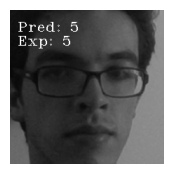

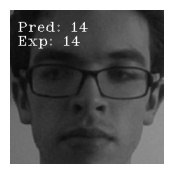

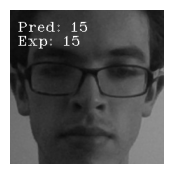

In [41]:
# 訓練模型
lbph_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_classifier.train(faces, ids)
lbph_classifier.write('lbph_classifier.yml')

# 讀取模型
lbph_face_classifier = cv2.face.LBPHFaceRecognizer_create()
lbph_face_classifier.read('./lbph_classifier.yml')

# 抓一張圖片起來做測試
image = Image.open('./jones_gabriel/person.1.1.jpg')
print(image.size)

# 做全部圖片的辨識
paths = [os.path.join('./jones_gabriel', f) for f in os.listdir('./jones_gabriel')]
for i, path in enumerate(paths):
  image = Image.open(path).convert('L')
  image_np = np.array(image, 'uint8')
  prediction, _ = lbph_face_classifier.predict(image_np)
  expected_output = int(path.split('.')[3])

  cv2.putText(image_np, 'Pred: ' + str(prediction), (10,30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
  cv2.putText(image_np, 'Exp: ' + str(expected_output), (10,50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))

  # 顯示圖片（只顯示三張）
  if i < 3:
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
    plt.figure(figsize=(4, 2))
    plt.axis('off')  # 隱藏坐標軸
    plt.imshow(image_np)

## 使用dlib做人臉辨識(失敗)

In [43]:
import os
"""
dlib.get_frontal_face_detector()
碼使用了 dlib 中的正面人臉檢測器。這個檢測器專門設計用於檢測圖像中的人臉，並返回人臉的位置。
它基於 HOG 特徵和支持向量機（SVM）的組合來實現人臉檢測。

dlib.shape_predictor()
使用了一個預訓練的模型，用於檢測圖像中人臉的 68 個面部特徵點（如眼睛、鼻子、嘴巴等）。
這些特徵點的檢測可以用於進一步的面部分析、表情識別等應用。

dlib.face_recognition_model_v1()
使用了一個預訓練的模型，用於從人臉圖像中提取描述符（face descriptors）。
描述符是一個向量，用於表示人臉的特徵。這些描述符可以用於人臉識別、人臉比對等應用。
"""
face_detector = dlib.get_frontal_face_detector()
points_detector = dlib.shape_predictor('./Weights/shape_predictor_68_face_landmarks.dat')
face_descriptor_extractor = dlib.face_recognition_model_v1('./Weights/dlib_face_recognition_resnet_model_v1.dat')

預測值
[ 6 16 12 11  4  5 19 25  7 24 18 20  2 21 23  1 22 12 11 15 14 16  8  9
 17 21 25 19]
解答
[19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19]


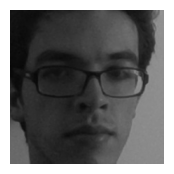

In [52]:
threshold = 0.5  # 設定閾值，用於判斷是否為同一人臉的閾值
predictions = []  # 存儲預測結果的列表
expected_outputs = []  # 存儲預期輸出的列表

# 構建測試圖片路徑列表
paths = [os.path.join('./jones_gabriel/', f) for f in os.listdir('./jones_gabriel/')]
for i, path in enumerate(paths):
    # 打開並轉換圖片為 RGB 格式
    image = Image.open(path).convert('RGB')
    image_np = np.array(image, 'uint8')
    
    # 找出圖片中的人臉位置
    face_detection = face_detector(image_np, 1)
    for face in face_detection:
        # 找出人臉的面部特徵點
        points = points_detector(image_np, face)
        # 計算人臉描述符
        face_descriptor = face_descriptor_extractor.compute_face_descriptor(image_np, points)
        face_descriptor = [f for f in face_descriptor]
        face_descriptor = np.asarray(face_descriptor, dtype=np.float64)
        face_descriptor = face_descriptor[np.newaxis, :]

        # 計算當前人臉描述符與已知人臉描述符之間的歐式距離
        distances = np.linalg.norm(face_descriptor - face_descriptors, axis=1)
        # 找到與當前人臉描述符距離最小的索引
        min_index = np.argmin(distances)
        # 找到距離最小的距離值
        min_distance = distances[min_index]
        # 如果最小距離小於等於閾值，則認為是同一人臉，否則視為未識別到的人臉
        if min_distance <= threshold:
            name_pred = int(path.split('.')[3])
        else:
            name_pred = 'Not identified'

        # 獲取真實的人臉標籤
        name_pred = int(path.split('.')[3])

        # 將預測結果和真實標籤添加到對應的列表中
        predictions.append(name_pred)
        expected_outputs.append(name_real)

        # 在圖片上標註預測結果和真實標籤
        cv2.putText(image_np, 'Pred: ' + str(name_pred), (10, 30), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))
        cv2.putText(image_np, 'Exp : ' + str(name_real), (10, 50), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0,0,0))

    # 顯示標註了預測結果和真實標籤的圖片(顯示一張就好)
    if i == 0:
        image = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB) # 將 OpenCV 中的 BGR 格式轉換為 RGB 格式，因為 Matplotlib 預期的是 RGB 格式
        plt.figure(figsize=(4, 2))
        plt.axis('off')  # 隱藏坐標軸
        plt.imshow(image_np)

# 將預測結果和真實標籤轉換為 NumPy 陣列
predictions = np.array(predictions)
expected_outputs = np.array(expected_outputs)

print("預測值")
print(predictions)
print("解答")
print(expected_outputs)